289
                             0   90  180  270  Horizontal
2023-06-21 00:00:00-07:00  0.0 -0.0 -0.0  0.0        -0.0
2023-06-21 00:05:00-07:00  0.0 -0.0 -0.0  0.0        -0.0
2023-06-21 00:10:00-07:00  0.0 -0.0 -0.0  0.0        -0.0
2023-06-21 00:15:00-07:00  0.0 -0.0 -0.0  0.0        -0.0
2023-06-21 00:20:00-07:00  0.0 -0.0 -0.0  0.0        -0.0
...                        ...  ...  ...  ...         ...
2023-06-21 23:40:00-07:00  0.0 -0.0 -0.0  0.0        -0.0
2023-06-21 23:45:00-07:00  0.0 -0.0 -0.0  0.0        -0.0
2023-06-21 23:50:00-07:00  0.0 -0.0 -0.0  0.0        -0.0
2023-06-21 23:55:00-07:00  0.0 -0.0 -0.0  0.0        -0.0
2023-06-22 00:00:00-07:00  0.0 -0.0 -0.0  0.0        -0.0

[289 rows x 5 columns]


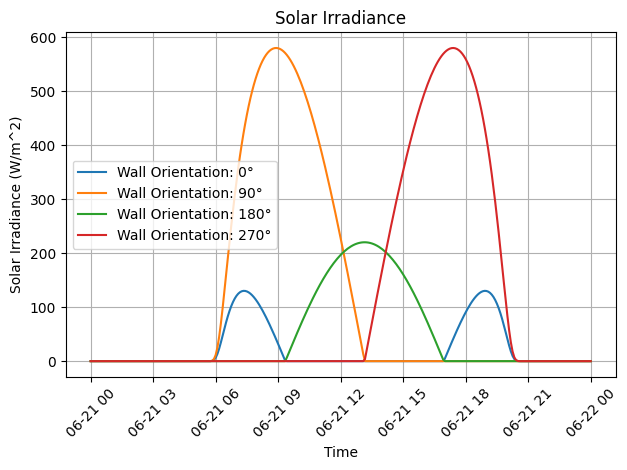

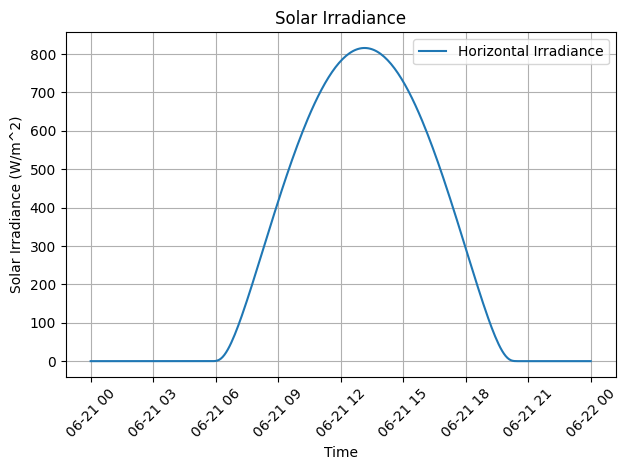

In [1]:
### Solar intensities calculator (for different walls orientations + horizontal roof) ###

import pandas as pd
import numpy as np
from pvlib import location, irradiance
import matplotlib.pyplot as plt

# Define time range
tz='US/Pacific'
start = pd.Timestamp('2023-06-21 00:00:00', tz=tz)
end = pd.Timestamp('2023-06-22 00:00:00', tz=tz)
time_index = pd.date_range(start, end, freq='5min')

# Calculate the time difference (dt) between consecutive timestamps in minutes
dt = (time_index[1] - time_index[0]).total_seconds() / 60   # in minutes
#print(dt)

time = np.array(time_index)
num_steps = len(time)
print(num_steps)


def get_solar_irradiance(latitude, longitude, tz, time_index):

    # Create location object
    site = location.Location(latitude, longitude, tz=tz)

    # Calculate solar position
    solar_position = site.get_solarposition(time_index)

    # Calculate clearsky irradiance
    clearsky = site.get_clearsky(time_index)
    
    
    # Create empty DataFrame to store results
    results = pd.DataFrame(index=time_index)

    # Calculate irradiance components for each wall orientation

    for surface_azimuth in [0, 90, 180, 270]:
        solar_irradiance = irradiance.get_total_irradiance(surface_tilt = 90,
                                                               surface_azimuth = surface_azimuth,
                                                               dni = clearsky['dni'],                       # DNI : Direct Normal Irradiation 
                                                               ghi = clearsky['ghi'],                       # GHI : Global Horizontal Irradiation
                                                               dhi = clearsky['dhi'],                       # DHI : Diffuse Horizontal Irradiation 
                                                               solar_zenith = solar_position['apparent_zenith'],
                                                               solar_azimuth = solar_position['azimuth'])
        
        solar_irradiance_horizontal = irradiance.get_total_irradiance(surface_tilt = 0,
                                                               surface_azimuth = 180,
                                                               dni = clearsky['dni'],                       # DNI : Direct Normal Irradiation 
                                                               ghi = clearsky['ghi'],                       # GHI : Global Horizontal Irradiation
                                                               dhi = clearsky['dhi'],                       # DHI : Diffuse Horizontal Irradiation 
                                                               solar_zenith = solar_position['apparent_zenith'],
                                                               solar_azimuth = solar_position['azimuth'])

        
        # Store the solar intensity in the DataFrame
        results.loc[time_index, surface_azimuth] = solar_irradiance['poa_direct']                  ## {poa_global : Total in-plane irradiance (W/m^2)/ poa_direct : Total in-plane beam irradiance (W/m^2)/ poa_diffuse : Total in-plane diffuse irradiance (W/m^2)/...
                                                                                                   ## ...poa_sky_diffuse : In-plane diffuse irradiance from sky (W/m^2)/ poa_ground_diffuse : In-plane diffuse irradiance from ground (W/m^2)}


    results.loc[time_index, ['Horizontal']] = solar_irradiance_horizontal ['poa_direct']
    return results

# Calculate solar irradiance
solar_irradiance = get_solar_irradiance(latitude=38.544907, longitude=-121.740517, tz='US/Pacific', time_index=time_index)

print (solar_irradiance)

# Plotting
fig, ax = plt.subplots()

for surface_azimuth in [0, 90, 180, 270]:
    ax.plot(solar_irradiance.index, solar_irradiance[surface_azimuth], label=f'Wall Orientation: {surface_azimuth}°')

ax.set_xlabel('Time')
ax.set_ylabel('Solar Irradiance (W/m^2)')
ax.set_title('Solar Irradiance')
ax.legend()
ax.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

plt.tight_layout()
plt.show()


# Plotting
fig, ax = plt.subplots()

ax.plot(solar_irradiance.index, solar_irradiance['Horizontal'], label='Horizontal Irradiance')

ax.set_xlabel('Time')
ax.set_ylabel('Solar Irradiance (W/m^2)')
ax.set_title('Solar Irradiance')
ax.legend()
ax.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

plt.tight_layout()
plt.show()

#print (solar_irradiance[0])   # print the values of solar intensities for a vertical wall with azimuth angle of 0
#print (solar_irradiance[90])   # print the values of solar intensities for a vertical wall with azimuth angle of 90
#print (solar_irradiance[180])   # print the values of solar intensities for a vertical wall with azimuth angle of 180
#print (solar_irradiance[270])   # print the values of solar intensities for a vertical wall with azimuth angle of 270
#print (solar_irradiance['Horizontal'])   # print the values of solar intensities for a horizontal roof




In [2]:

## Price signal modification from 2-peak example
df_price_hourly = pd.read_csv('price_two_peak_example.csv')

df_price_hourly.index = pd.date_range(start='2023-06-21', periods=24, freq='H')

# Set the index to be the datetime range for a day with 5-minute intervals
datetime_range = pd.date_range(start='2023-06-21', periods=288, freq='5min')

# Duplicate the hourly values to match the datetime range
df_price_5min = df_price_hourly.reindex(datetime_range, method='pad')

# Print the expanded dataframe
print(len (df_price_5min['price']))

print(df_price_5min.loc[df_price_5min.index[0], 'price'])

################################################################################################################

## Ambient temperature
df_amb_temp = pd.read_csv('One_day_MFHP_5_min.csv')

df_amb_temp.index = pd.date_range(start='2023-06-21', periods=288, freq='5min')


# Print the expanded dataframe
print(len (df_amb_temp['T_amb']))

print(df_amb_temp.loc[df_amb_temp.index[0], 'T_amb'])

################################################################################################################
## Hot water drawn
df_one_day = pd.read_csv('One_day_MFHP_5_min.csv')

df_one_day.index = pd.date_range(start='2023-06-21', periods=288, freq='5min')


# Print the expanded dataframe
print(len (df_one_day['m_dot_water']))

print(df_one_day.loc[df_one_day.index[0], 'm_dot_water'])

288
0.011
288
25.64366667
288
0.0


In [3]:

#### Input parameters for building
## input parameters:
c_p_air = 1004       #J/kg.k
rho_air = 1.225      #kg/m3
h_ceil = 4            #(m)
A_floor = 185          #(m2) (assuming a square 6.32 m by 6.32 m space)
A_roof = A_floor
v_air = h_ceil * A_floor    #(m3)
A_wall = 4* (np.sqrt(185) * h_ceil)  # (m2)
r_env = 3.249          # (m2.k/W)   5 to 15
alpha = 0.35       # absorptivity of walls (Red clay brick)
SHGC = 0.15       # solar heat gain coefficient of windows
c_air = c_p_air*rho_air*v_air   #J/K
c_walls = 25000   #J/m2.K
c_walls = c_walls * (A_wall + A_roof)
c_i = c_walls + c_air

## Walls Areas [m2] 
a_wall_n = (np.sqrt(A_floor) * h_ceil)
a_wall_s = (np.sqrt(A_floor) * h_ceil)
a_wall_w = 0
a_wall_e = (np.sqrt(A_floor) * h_ceil) - (3*2)

## Windows Areas [m2] 
a_wind_n = 0
a_wind_s = 0
a_wind_w = 0
a_wind_e = 3*2

p_solar_env = [0]*num_steps
p_solar_wind = [0]*num_steps
p_solar_roof = [0]*num_steps
p_solar_total = [0]*num_steps

    



for i in range(num_steps):
    p_solar_env[i] = alpha * (a_wall_n * solar_irradiance[0][i] + a_wall_e * solar_irradiance[90][i] + a_wall_s * solar_irradiance[180][i] + a_wall_w * solar_irradiance[270][i])
    p_solar_wind[i] = SHGC * (a_wind_n * solar_irradiance[0][i] + a_wind_e * solar_irradiance[90][i] + a_wind_s * solar_irradiance[180][i] + a_wind_w * solar_irradiance[270][i])
    p_solar_roof [i] = alpha * (A_roof * solar_irradiance['Horizontal'][i])
    p_solar_total [i] = p_solar_env[i] + p_solar_wind[i] + p_solar_roof [i]




### Input parametrs for water storage tank
c_p_w = 4200   # J/kg.k
#UA = 0.58      # W/k
UA = 2.5     # W/k
V_tank = 0.21   # m3
rho_water = 1000 # kg/m3
r_wall = 1/UA   #  k/W
c_w = c_p_w * rho_water * V_tank    # J/k

# Create arrays to store the state values
T_amb = [0]*num_steps
m_dot_w = [0]*num_steps
T_c = [0]*num_steps
cost_elec = [0]*(num_steps-1)
for i in range(num_steps-1):
    T_amb [i] = df_one_day.loc[df_one_day.index[i],'T_Outdoor_Temperature_C'] #deg C
    m_dot_w [i] = df_one_day.loc[df_one_day.index[i],'m_dot_water']  # kg/s
    cost_elec[i] = df_price_5min.loc[df_price_5min.index[i],'price']
    T_c [i] = 15




## Maximum heating capacities
Q_dot_FCU_AC = -11.62 * 1000   # Watt
P_elec_AC = 4.18    # KW


Q_dot_cond_WH = 10.76 * 1000   # Watt
P_elec_WH = 4.41      # KW

Q_dot_FCU_sim = -5.61 * 1000   # Watt
Q_dot_cond_sim = 9.66 * 1000    # Watt
P_elec_sim = 4.56      # KW

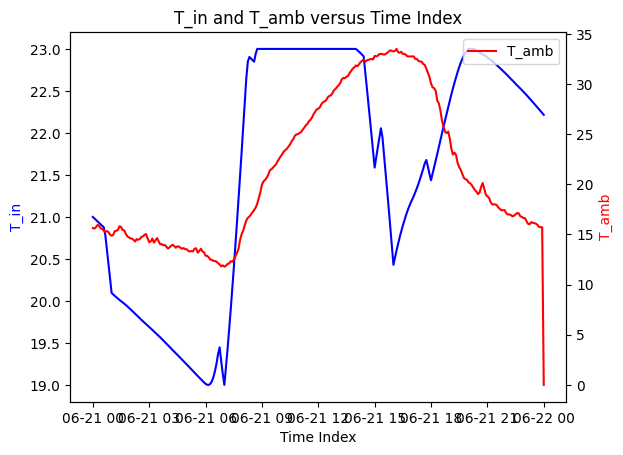

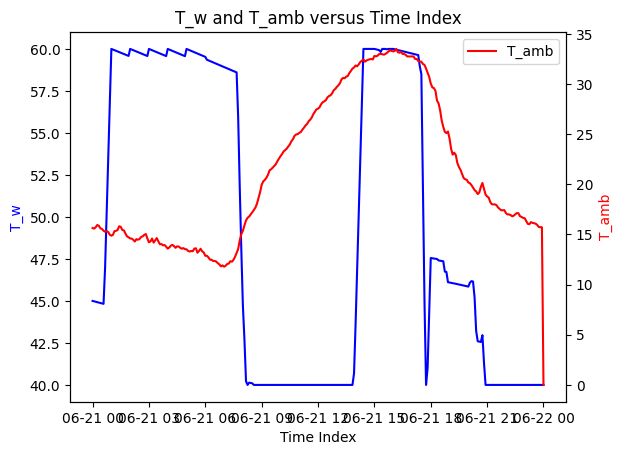

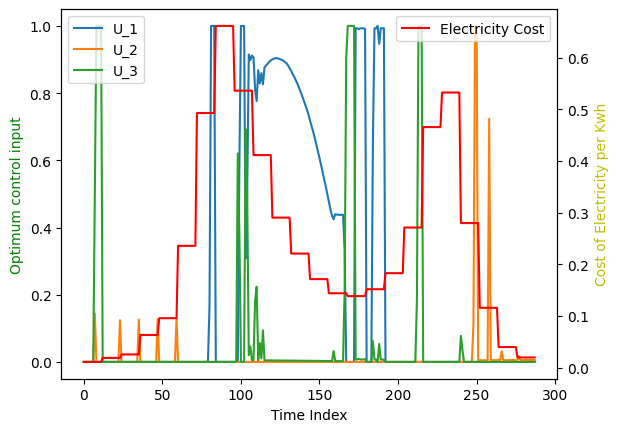

In [4]:
## total mode optimization
import numpy as np
from docplex.mp.model import Model


# Create the MILP model
total_opt = Model(name="total mode optimization")

# Add the decision variables
T_in = [total_opt.continuous_var(name=f"T_in_{i}", lb=19, ub=23) for i in range(num_steps)]
T_w = [total_opt.continuous_var(name=f"T_w_{i}", lb=40, ub=60) for i in range(num_steps)]
# u_1 = [total_opt.binary_var(name=f"u_1_{i}") for i in range(num_steps)]    ## u_1 = v_ac
# u_2 = [total_opt.binary_var(name=f"u_2_{i}") for i in range(num_steps)]    ## u_2 = v_wh
# u_3 = [total_opt.binary_var(name=f"u_3_{i}") for i in range(num_steps)]    ## u_3 = v_wh

u_1 = [total_opt.continuous_var(name=f"u_1_{i}", lb=0, ub=1) for i in range(num_steps)] ## ## u_1 = v_ac
u_2 = [total_opt.continuous_var(name=f"u_2_{i}", lb=0, ub=1) for i in range(num_steps)]  ## u_2 = v_wh
u_3 = [total_opt.continuous_var(name=f"u_3_{i}", lb=0, ub=1) for i in range(num_steps)] ## u_3 = v_sim
#u_3 = [total_opt.binary_var(name=f"u_3_{i}") for i in range(num_steps)]    ## u_3 = v_wh
#T_c = [total_opt.continuous_var(name=f"T_c_{i}", lb=15, ub=15) for i in range(num_steps)]
#Q_gain = [total_opt.continuous_var(name=f"Q_gain_{i}", lb=0, ub=0) for i in range(num_steps)]




# state space equations
for i in range(num_steps - 1):
    # Calculate dT_w/dt
    total_opt.add_constraint(T_w[i + 1] == T_w[i] + (dt *60) * ((-(((1/(c_w*r_wall)) 
                                         + ((m_dot_w[i]*c_p_w)/c_w))* T_w[i]) 
                                        + ((Q_dot_cond_WH/c_w) * u_2 [i])
                                        + ((Q_dot_cond_sim/c_w) * u_3 [i]) 
                                         + ((1/(c_w*r_wall)) * T_amb[i]) + (((m_dot_w[i]*c_p_w)/c_w)*T_c[i]))))

    # total_opt.add_constraint(T_w[i+1] == T_w[i])

    #total_opt.add_constraint(T_w[i + 1] == T_w[i] + (dt *60) * ((-(((1/(c_w*r_wall)) + ((m_dot_w*c_p_w)/c_w))* T_w[i]) + ((Q_dot_cond_WH/c_w) * u_2 [i]) + ((1/(c_w*r_wall)) * T_amb) + (((m_dot_w*c_p_w)/c_w)*T_c))))

    # Calculate dT_i/dt
    total_opt.add_constraint(T_in[i+1] == T_in[i] + (dt*60) * (
         (((A_wall+A_roof)/(r_env*c_i))*(T_amb[i] - T_in[i])) 
         + ((1/(c_i)) * ((u_1[i] * Q_dot_FCU_AC) + (u_3[i] * Q_dot_FCU_sim) + p_solar_env[i] + p_solar_wind[i] ))))
    # total_opt.add_constraint(T_in[i+1] == T_in[i])
    
    total_opt.add_constraint(u_1[i] + u_2[i] + u_3[i] <=1)
    
    

#Initial condition
total_opt.add_constraint(T_in[0] == 21)
total_opt.add_constraint(T_w[0] == 45)

# Define the objective function
J = []
for i in range(num_steps - 1):
    J.append( (1/3600) *(dt*60)* (P_elec_AC * u_1[i] + P_elec_WH * u_2[i] + P_elec_sim * u_3[i]) * cost_elec[i] )
objective = total_opt.sum(J[i]   for i in range(num_steps-1))
total_opt.set_objective("minimize", objective)




# Solve the model
solution_tot = total_opt.solve()



# Collect the values of T_in and T_amb from the solved model
T_in_values = [solution_tot[T_in[i]] for i in range(num_steps)]
T_w_values = [solution_tot[T_w[i]] for i in range(num_steps)]

## Optimized control inputs
u_1_values = [solution_tot[u_1[i]] for i in range(num_steps)]
u_2_values = [solution_tot[u_2[i]] for i in range(num_steps)]
u_3_values = [solution_tot[u_3[i]] for i in range(num_steps)]


# Calculating the optimized objective cost
opt_cost = [solution_tot[objective]]


# Create the time index (assuming it's defined somewhere in your code)
time_index = range(num_steps)


# Plot T_in versus time_index
fig, ax1 = plt.subplots()
# Plot T_in_values on the first axis
ax1.plot(time, T_in_values, label='T_in', color='blue')
ax1.set_xlabel('Time Index')
ax1.set_ylabel('T_in', color='blue')



# Create a second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot T_amb on the second axis
ax2.plot(time, T_amb, label='T_amb', color='red')
ax2.set_ylabel('T_amb', color='red')

plt.title('T_in and T_amb versus Time Index')
plt.legend()
plt.show()








# Plot T_w versus time_index
fig, ax1 = plt.subplots()
# Plot T_w_values on the first axis
ax1.plot(time, T_w_values, label='T_in', color='blue')
ax1.set_xlabel('Time Index')
ax1.set_ylabel('T_w', color='blue')



# Create a second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot T_amb on the second axis
ax2.plot(time, T_amb, label='T_amb', color='red')
ax2.set_ylabel('T_amb', color='red')

plt.title('T_w and T_amb versus Time Index')
plt.legend()
plt.show()




# plot u_input and cost of electricity
fig, ax1 = plt.subplots()
ax1.plot(time_index[0:288], u_1_values[0:288], label='U_1')
plt.xlabel('Time Index')
ax1.set_ylabel('Optimum control input', color='b')

# plot u_input and cost of electricity
ax1.plot(time_index[0:288], u_2_values[0:288], label='U_2')
ax1.set_ylabel('Optimum control input', color='r')

# plot u_input and cost of electricity
ax1.plot(time_index[0:288], u_3_values[0:288], label='U_3')
ax1.set_ylabel('Optimum control input', color='g')


# Create a twin Axes object with the same x-axis
ax2 = ax1.twinx()

# Plot second dataset on the secondary y-axis
ax2.plot(time_index[0:288], cost_elec, 'r-', label='Electricity Cost')
ax2.set_ylabel('Cost of Electricity per Kwh', color='y')

# Show legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


In [5]:
print (u_2_values[0])

0


In [6]:
def model_T_w (T_w, u_2, u_3, dt):
    T_w_new = 0
    T_w_new = T_w + (dt *60) * ((-(((1/(c_w*r_wall)) 
                                         + ((m_dot_w[i]*c_p_w)/c_w))* T_w) 
                                        + ((Q_dot_cond_WH/c_w) * u_2)
                                        + ((Q_dot_cond_sim/c_w) * u_3 ) 
                                         + ((1/(c_w*r_wall)) * T_amb[i]) + (((m_dot_w[i]*c_p_w)/c_w)*T_c[i])))
    return T_w_new


def model_T_in (T_in, u_1, u_3, dt):
    T_in_new= 0
    T_in_new = T_in + (dt*60) * (
         (((A_wall+A_roof)/(r_env*c_i))*(T_amb[i] - T_in)) 
         + ((1/(c_i)) * ((u_1 * Q_dot_FCU_AC) + (u_3 * Q_dot_FCU_sim) + p_solar_env[i] + p_solar_wind[i] )))
    return T_in_new

In [68]:
T_in_init = [0]*num_steps
T_w_init = [0]*num_steps
T_in_init[0] = 21
T_w_init[0] = 45

#U = pd.DataFrame()

for j in range(num_steps-1):
   
    # T_in = [0]*(num_steps-j)
    # T_w = [0]*(num_steps-j)

    # u_1 = [0]*(num_steps-j)
    # u_2 = [0]*(num_steps-j)
    # u_3 = [0]*(num_steps-j)
    
    total_opt = Model(name="total mode optimization")

    # Add the decision variables
    T_in = [total_opt.continuous_var(name=f"T_in_{i}", lb=10, ub=40) for i in range(num_steps-j)]
    T_w = [total_opt.continuous_var(name=f"T_w_{i}", lb=10, ub=100) for i in range(num_steps-j)]

    u_1 = [total_opt.continuous_var(name=f"u_1_{i}", lb=0, ub=1) for i in range(num_steps-j)] ## ## u_1 = v_ac
    u_2 = [total_opt.continuous_var(name=f"u_2_{i}", lb=0, ub=1) for i in range(num_steps-j)]  ## u_2 = v_wh
    u_3 = [total_opt.continuous_var(name=f"u_3_{i}", lb=0, ub=1) for i in range(num_steps-j)] ## u_3 = v_sim

    # for i in range(j+1):
    #     total_opt.add_constraint(T_in[i] == T_in_init[i])
    #     total_opt.add_constraint(T_w[i] == T_w_init[i])
    total_opt.add_constraint(T_in[0] == T_in_init[j])
    total_opt.add_constraint(T_w[0] == T_w_init[j])
    
    # for i in range(j):
    #     T_in[i] == T_in_init[i]
    #     T_w[i] == T_w_init[i]

    # state space equations
    for i in range((num_steps-j-1)):
        # Calculate dT_w/dt
        total_opt.add_constraint(T_w[i + 1] == T_w[i] + (dt *60) * ((-(((1/(c_w*r_wall)) 
                                            + ((m_dot_w[i]*c_p_w)/c_w))* T_w[i]) 
                                            + ((Q_dot_cond_WH/c_w) * u_2 [i])
                                            + ((Q_dot_cond_sim/c_w) * u_3 [i]) 
                                            + ((1/(c_w*r_wall)) * T_amb[i+j]) + (((m_dot_w[i+j]*c_p_w)/c_w)*T_c[i+j]))))

        # total_opt.add_constraint(T_w[i+1] == T_w[i])
     

        # Calculate dT_i/dt
        total_opt.add_constraint(T_in[i+1] == T_in[i] + (dt*60) * (
            (((A_wall+A_roof)/(r_env*c_i))*(T_amb[i+j] - T_in[i])) 
            + ((1/(c_i)) * ((u_1[i] * Q_dot_FCU_AC) + (u_3[i] * Q_dot_FCU_sim) + p_solar_env[i+j] + p_solar_wind[i+j] ))))
    
    
        # total_opt.add_constraint(T_in[i+1] == T_in[i])
            
        total_opt.add_constraint(u_1[i] + u_2[i] + u_3[i] <=1)
        
        
            #Initial condition


    
    #J = []
    J = 0
    # Define the objective function
    for i in range((num_steps-j-1)):
        J = J+ ( (1/3600) *(dt*60)* (P_elec_AC * u_1[i] + P_elec_WH * u_2[i] + P_elec_sim * u_3[i]) * cost_elec[i+j] )
    #objective = total_opt.sum(J[i]   for i in range(j,num_steps-1))
    objective = J
    total_opt.set_objective("minimize", objective)

    # Solve the model
    solution_tot = total_opt.solve()

    # Collect the values of T_in and T_amb from the solved model
    T_in_values = [solution_tot[T_in[i]] for i in range((num_steps-j-1))]
    T_w_values = [solution_tot[T_w[i]] for i in range((num_steps-j-1))]

    ## Optimized control inputs
    u_1_values = [solution_tot[u_1[i]] for i in range((num_steps-j-1))]
    u_2_values = [solution_tot[u_2[i]] for i in range((num_steps-j-1))]
    u_3_values = [solution_tot[u_3[i]] for i in range((num_steps-j-1))]


    # Calculating the optimized objective cost
    # opt_cost = [solution_tot[objective]]  

    
    T_w_init[j+1] = model_T_w (T_w_values[0], u_2_values[0], u_3_values[0], dt)
    T_in_init[j+1] =model_T_in (T_in_values[0], u_1_values[0], u_3_values[0], dt)
    # U.loc[j] = { 'U1':u_1_values[0], 'U2': u_2_values[0], 'U3': u_3_values[0]}
    row_values = [u_1_values[0], u_2_values[0], u_3_values[0]]
    #U = U.append(pd.Series(row_values, index=U.columns), ignore_index=T)
    
    print (T_in_init[j+1])
    print (T_w_init[j+1])
    print(u_1_values[0])
    print(j)
    

ValueError: Length of values (3) does not match length of index (0)

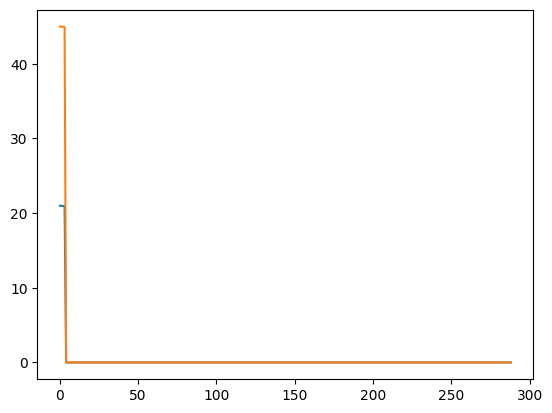

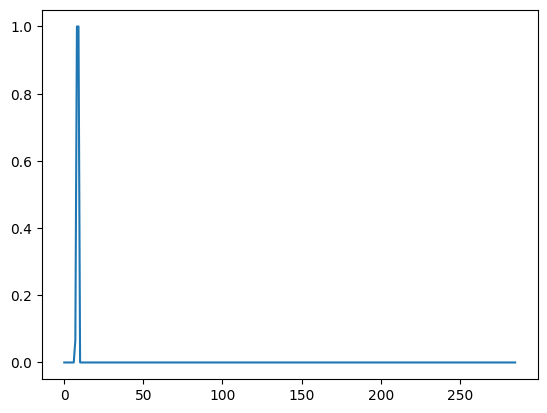

In [65]:
plt.plot(T_in_init)
plt.plot(T_w_init)
fig, ax = plt.subplots()
plt.plot(u_1_values)